# 지상 관측자료 기입

https://mesonet.agron.iastate.edu/request/download.phtml?network=KR__ASOS 에서 자료 다운

In [20]:
# 필요한 패키지 임포트
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components, altimeter_to_sea_level_pressure
from metpy.cbook import get_test_data
from metpy.plots import (add_metpy_logo, simple_layout, StationPlot,
                         StationPlotLayout, wx_code_map)
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units

# 'ECCODES_DEFINITION_PATH'를 'C:\Users\Dong-Gyu Hyeon\miniconda3\Library\share\eccodes\definitions'로 설정해야 함
# Windows 10 사용자: 내PC > 고급시스템설정 > 환경변수 > 시스템변수 > 새로만들기
# C:\Users\Dong-Gyu Hyeon\ 이 부분은 본인의 경로에 맞게 고쳐주세요

In [21]:
#asos 지상관측자료
path1 = r'/Users/hojjunekim/Desktop/HW1/asos_201020_KR.txt'
path2 = r'/Users/hojjunekim/Desktop/HW1/asos_201020_JP.txt'
path3 = r'/Users/hojjunekim/Desktop/HW1/asos_201020_CN.txt'

cols = (0,1,2,3,4,5,7,8,10,11,14,15,16,22)
var = ['stid','time','lon','lat','air_temperature','dew_point_temperature',\
        'wind_dir','wind_speed','altimeter','sea_level_pressure',\
        'sky1','sky2','sky3','weather']

kr = pd.read_csv(path1, usecols=cols, names=var, na_values='M', header=0)
stid = ['QEP', 'RKNN', 'RKPC', 'RKPK','RKSO', 'RKSY', 'QEN'] # 광주, 강릉, 부산, 제주, 서울, 대관령
kr.set_index('stid', inplace=True)
kr = kr.loc[stid]
kr = kr.reset_index()

jp = pd.read_csv(path2, usecols=cols, names=var, na_values='M', header=0)
stid = ['ROIG', 'ROAH', 'RJKN', 'RJFG', 'RJAW',  # 이시가키, 오키나와, 토쿠노시마, 타네가시마, 이와지마
         'RJFK', 'RJFF', 'RJOS', 'RJOW', 'RJOO',  #가고시마, 후쿠오카, 토쿠시마, 이와미, 오사카
         'RJTF', 'RJSF', 'RJNT', 'RJSS',  # 도쿄, 후쿠시마, 토야마, 센다이
         'RJSK', 'RJSA', 'RJCC']                 # 아키타, 아오모리, 삿포로
jp.set_index('stid', inplace=True)
jp = jp.loc[stid]
jp = jp.reset_index()

cn = pd.read_csv(path3, usecols=cols, names=var, na_values='M', header=0)

df = pd.concat([kr,jp,cn])
df.set_index('time', inplace=True)
df = df.loc['2020-10-20 00:00']
df = df.reset_index()

In [22]:
# 운량 정보가 층별로 CLR, FEW, SCT, BKN, OVC로 되어 있으므로 이를 우리가 아는 10분운량으로 바꿔줘야 함
cloud = df.loc[:,['sky1','sky2','sky3']]
mapping = {'CLR':0, 'FEW':1, 'SCT':3, 'BKN':6, 'OVC':8, 'NCD':np.nan, 'NSC':np.nan}
cloud_convert = cloud.applymap(lambda s: mapping.get(s) if s in mapping else s)
cloud_fraction = cloud_convert.max(axis=1,skipna=True)
cloud_fraction.name = 'cloud_fraction'
df = df.join(cloud_fraction, )
df = df.dropna(how='any', subset=['wind_speed', 'wind_dir', 'altimeter'])

In [23]:
data = {}
data['longitude'] = df['lon'].values
data['latitude'] = df['lat'].values
data['air_temperature'] = df['air_temperature'].values * units.degF
data['dew_point_temperature'] = df['dew_point_temperature'].values * units.degF
data['air_temperature'] = data['air_temperature'].to(units.degC)
data['dew_point_temperature'] = data['dew_point_temperature'].to(units.degC)
data['altimeter'] = df['altimeter'].values * 1013.25 / 29.92 * units('mbar')



In [24]:
# 해면기압 자료를 수은기둥 높이 해면경정으로 이용

# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.altimeter_to_sea_level_pressure.html 참고

# 관측소 고도 자료 
path4 = r'/Users/hojjunekim/Desktop/HW1/iem_kr_station.txt'
path5 = r'/Users/hojjunekim/Desktop/HW1/iem_jp_station.txt'
path6 = r'/Users/hojjunekim/Desktop/HW1/iem_cn_station.txt'
st1 = pd.read_csv(path4)
st2 = pd.read_csv(path5)
st3 = pd.read_csv(path6)
df3 = pd.concat([st1, st2, st3])
df3 = df3.dropna(how='any', subset=['elev'])
df3.set_index('stid', inplace=True)
stid = df['stid']
data['elevation'] = df3['elev'][stid].values * units.m

# 해면경정
data['sea_level_pressure'] = altimeter_to_sea_level_pressure(data['altimeter'],data['elevation'], data['air_temperature'])

In [25]:
u, v = wind_components(df['wind_speed'].values * units('knots'),
                       df['wind_dir'].values * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
data['cloud_coverage'] = df['cloud_fraction'].fillna(0).values.astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
wx_text = df['weather'].fillna('')
data['present_weather'] = [wx_code_map[s.split()[0] if ' ' in s else s] for s in wx_text]

In [26]:
proj = ccrs.LambertConformal(central_longitude=120, central_latitude=35,
                             standard_parallels=[35])

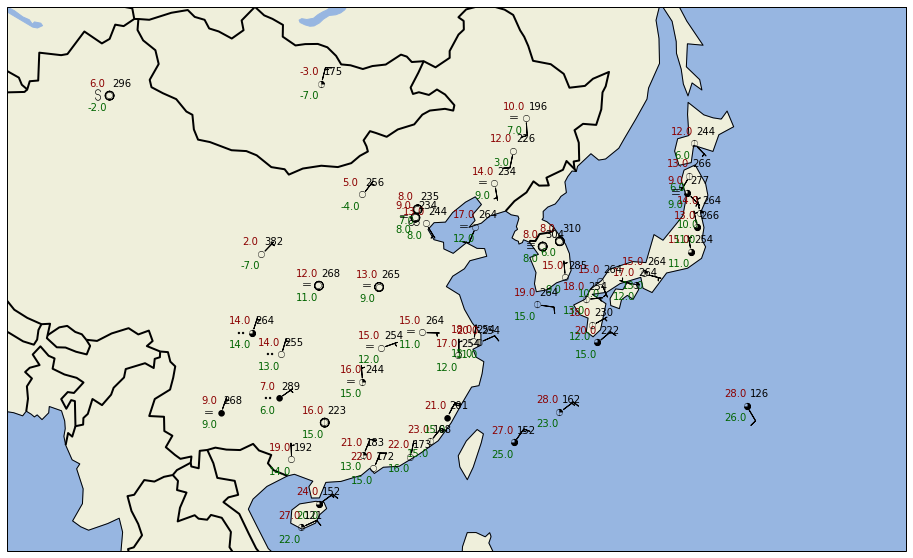

In [27]:
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)

# Create the figure and an axes set to the projection
plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
#ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.set_extent((90, 150, 15, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

plt.show()

# GFS 분석장 활용 지상 일기도

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs 에서 자료 다운

In [28]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import cfgrib



In [29]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

In [30]:
ds2 = xr.open_dataset(r'/Users/hojjunekim/Desktop/snu_weatheranalysis-master/gfs_3_20201020_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'meanSea'},'indexpath': ''})
ds2

2020-10-30 23:18:20,271 INFO missing from GRIB stream: 'number'
2020-10-30 23:18:20,272 INFO missing from GRIB stream: 'directionNumber'
2020-10-30 23:18:20,272 INFO missing from GRIB stream: 'frequencyNumber'
2020-10-30 23:18:20,294 INFO missing from GRIB stream: 'number'
2020-10-30 23:18:20,295 INFO missing from GRIB stream: 'directionNumber'
2020-10-30 23:18:20,295 INFO missing from GRIB stream: 'frequencyNumber'


<xarray.Dataset>
Dimensions:     (latitude: 181, longitude: 360)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     int64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  datetime64[ns] ...
Data variables:
    mslet       (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-10-30T23:18:20 GRIB to CDM+CF via cfgrib-0....

In [31]:
# Select and grab data, at/lon values 
pres = ds2['prmsl'].sel(latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
dt = datetime(2020, 10, 20, 0)
vtime = datetime.strptime(str(ds2.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

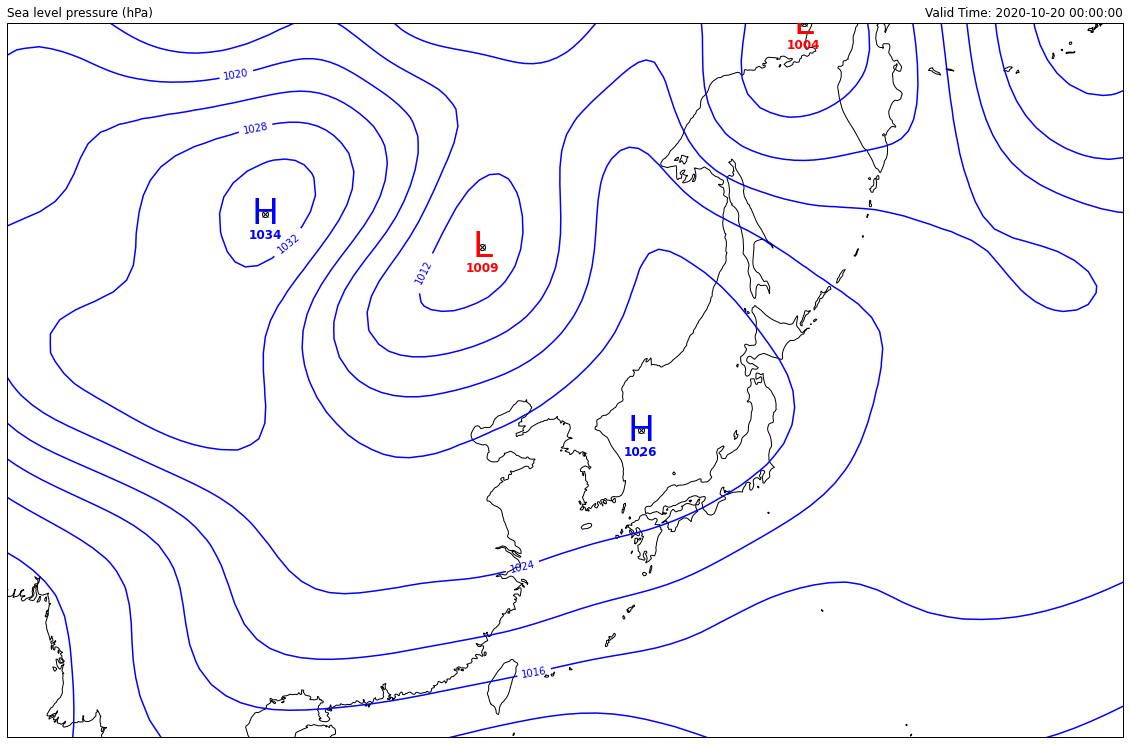

In [32]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(20, 10))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')


# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

# ERA5 재분석장 활용 지상 일기도

In [33]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': '2020',
        'month': '10',
        'day': '20',
        'time': '00:00',
        'grid': [1.0, 1.0],
    },
    'era5_sfc_2020102000.nc')

2020-10-30 23:18:24,800 INFO Welcome to the CDS
2020-10-30 23:18:24,802 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-30 23:18:26,040 INFO Request is completed
2020-10-30 23:18:26,041 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1603963682.3787348-1968-28-32eb4749-f306-4cc8-a47e-3c639755e1e1.nc to era5_sfc_2020102000.nc (258K)
2020-10-30 23:18:28,181 INFO Download rate 120.6K/s


Result(content_length=264176,content_type=application/x-netcdf,location=http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1603963682.3787348-1968-28-32eb4749-f306-4cc8-a47e-3c639755e1e1.nc)

In [34]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind'],
        'pressure_level': 
        ['200', '300', '500','700', '850', '925','1000'],
        'year': '2020',
        'month': '10',
        'day': '20',
        'time': '00:00',
        'grid': [1.0, 1.0],
    },
    'era5_pres_2020102000.nc')

2020-10-30 23:18:29,407 INFO Welcome to the CDS
2020-10-30 23:18:29,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-10-30 23:18:30,633 INFO Request is completed
2020-10-30 23:18:30,635 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1604063364.5718796-19329-19-f741e495-6020-4c5f-b316-8d82b9a01b04.nc to era5_pres_2020102000.nc (3.5M)
2020-10-30 23:18:36,733 INFO Download rate 585.2K/s 


Result(content_length=3653260,content_type=application/x-netcdf,location=http://136.156.132.210/cache-compute-0005/cache/data3/adaptor.mars.internal-1604063364.5718796-19329-19-f741e495-6020-4c5f-b316-8d82b9a01b04.nc)

In [35]:
import xarray as xr

dt = xr.open_dataset('era5_sfc_2020102000.nc')
dt

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2020-10-20
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-29 09:28:03 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [36]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [37]:
# Select and grab data, at/lon values 
pres = dt['msl'].sel(time='2020-10-20',latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
dtt = datetime(2020, 10, 20, 0)
vtime = datetime.strptime(str(dt.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

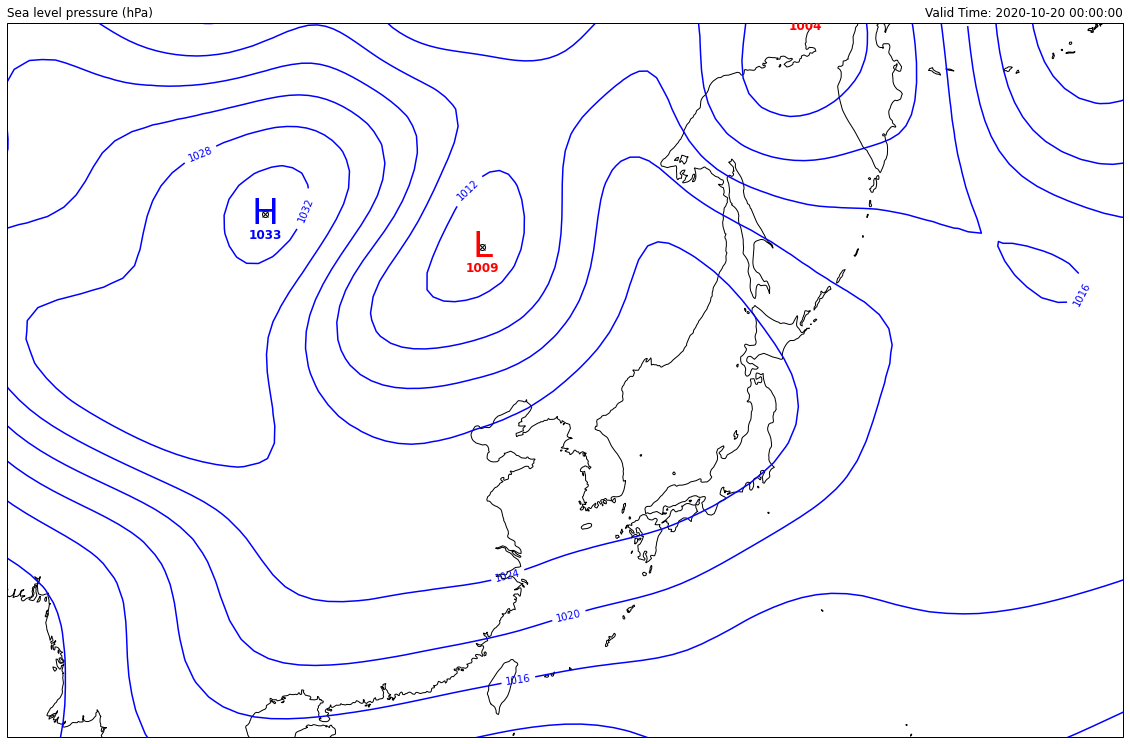

In [38]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(20, 10))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

# 분석 일기도

지상 관측자료+지상 일기도(grid or era5)

## 지상 관측자료 + GFS 활용 지상 일기도 결합

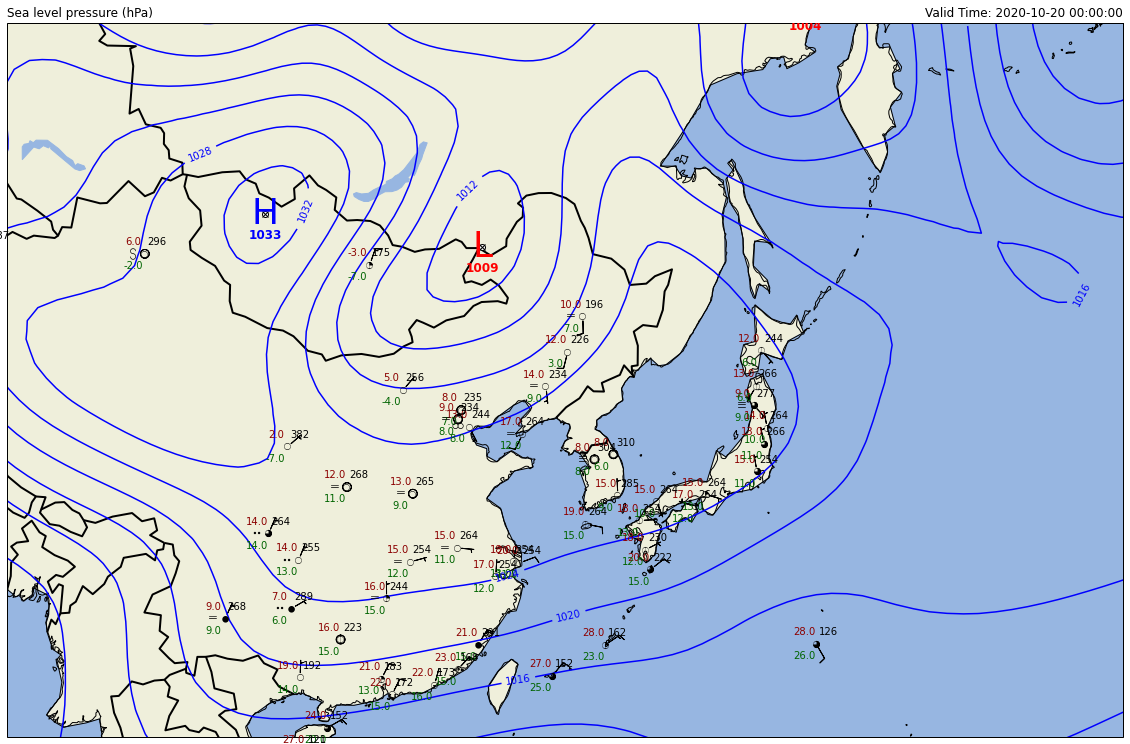

In [39]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
#plt.rcParams['savefig.dpi'] = 255
fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1, 1, 1, projection=proj)
#fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

###################

custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)

# Create the figure and an axes set to the projection
#plt.rcParams['savefig.dpi'] = 255
#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
#ax.set_extent((90, 150, 20, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

###################

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')


# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

## 지상 관측자료 + ERA5 활용 지상 일기도

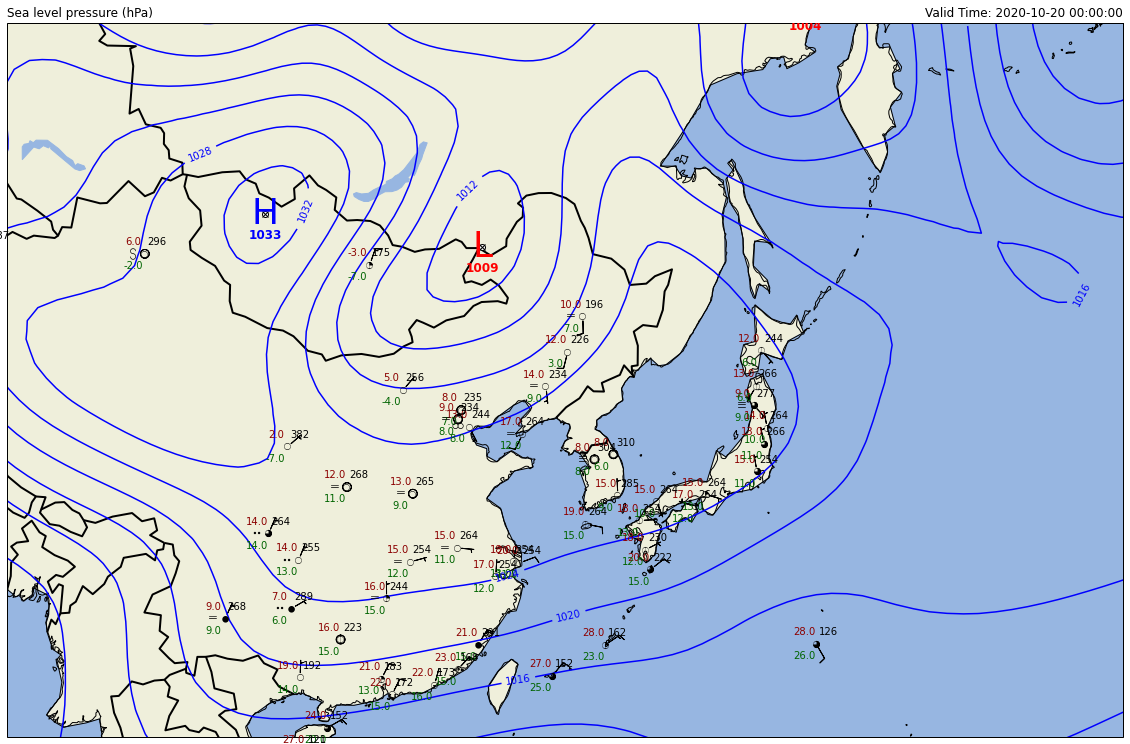

In [40]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(20, 10))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())



###################

custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots', length=5)
custom_layout.add_value('NW', 'air_temperature', fmt='.1f', units='degC', color='darkred', fontsize=10)
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.1f', units='degC',
                        color='darkgreen', fontsize=10)
custom_layout.add_value('NE', 'sea_level_pressure', fmt=lambda v: format(10 * v, '.0f')[-3:], units='mbar', color='black', fontsize=10)
custom_layout.add_symbol('W','present_weather', current_weather)
custom_layout.add_symbol('C','cloud_coverage', sky_cover, fontsize=7)

# Create the figure and an axes set to the projection
#plt.rcParams['savefig.dpi'] = 255
#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
#ax.set_extent((90, 150, 20, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
custom_layout.plot(stationplot, data)

###################



# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)